# exp44

lag_diff,c3のknn


https://www.kaggle.com/code/ragnar123/amex-lgbm-dart-cv-0-7977

In [1]:
# ====================================================
# Library
# ====================================================
import gc
import warnings
warnings.filterwarnings('ignore')
import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
import itertools

import lightgbm as lgb
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [2]:

# ====================================================
# Get the difference
# ====================================================
def get_difference(data, num_features):
    df1 = []
    customer_ids = []
    for customer_id, df in tqdm(data.groupby(['customer_ID'])):
        # Get the differences
        diff_df1 = df[num_features].diff(1).iloc[[-1]].values.astype(np.float32)
        # Append to lists
        df1.append(diff_df1)
        customer_ids.append(customer_id)
    # Concatenate
    df1 = np.concatenate(df1, axis = 0)
    # Transform to dataframe
    df1 = pd.DataFrame(df1, columns = [col + '_diff1' for col in df[num_features].columns])
    # Add customer id
    df1['customer_ID'] = customer_ids
    return df1

# ====================================================
# Read & preprocess data and save it to disk
# ====================================================
def read_preprocess_data():
    train = pd.read_parquet('/content/data/train.parquet')
    features = train.drop(['customer_ID', 'S_2'], axis = 1).columns.to_list()
    cat_features = [
        "B_30",
        "B_38",
        "D_114",
        "D_116",
        "D_117",
        "D_120",
        "D_126",
        "D_63",
        "D_64",
        "D_66",
        "D_68",
    ]
    num_features = [col for col in features if col not in cat_features]
    print('Starting training feature engineer...')
    train_num_agg = train.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
    train_num_agg.columns = ['_'.join(x) for x in train_num_agg.columns]
    train_num_agg.reset_index(inplace = True)
    train_cat_agg = train.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
    train_cat_agg.columns = ['_'.join(x) for x in train_cat_agg.columns]
    train_cat_agg.reset_index(inplace = True)
    train_labels = pd.read_csv('../input/amex-default-prediction/train_labels.csv')
    # Transform float64 columns to float32
    cols = list(train_num_agg.dtypes[train_num_agg.dtypes == 'float64'].index)
    for col in tqdm(cols):
        train_num_agg[col] = train_num_agg[col].astype(np.float32)
    # Transform int64 columns to int32
    cols = list(train_cat_agg.dtypes[train_cat_agg.dtypes == 'int64'].index)
    for col in tqdm(cols):
        train_cat_agg[col] = train_cat_agg[col].astype(np.int32)
    # Get the difference
    train_diff = get_difference(train, num_features)
    train = train_num_agg.merge(train_cat_agg, how = 'inner', on = 'customer_ID').merge(train_diff, how = 'inner', on = 'customer_ID').merge(train_labels, how = 'inner', on = 'customer_ID')
    del train_num_agg, train_cat_agg, train_diff
    gc.collect()
    test = pd.read_parquet('../input/amex-fe/test_fe.parquet')
    print('Starting test feature engineer...')
    test_num_agg = test.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]
    test_num_agg.reset_index(inplace = True)
    test_cat_agg = test.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]
    test_cat_agg.reset_index(inplace = True)
    # Transform float64 columns to float32
    cols = list(test_num_agg.dtypes[test_num_agg.dtypes == 'float64'].index)
    for col in tqdm(cols):
        test_num_agg[col] = test_num_agg[col].astype(np.float32)
    # Transform int64 columns to int32
    cols = list(test_cat_agg.dtypes[test_cat_agg.dtypes == 'int64'].index)
    for col in tqdm(cols):
        test_cat_agg[col] = test_cat_agg[col].astype(np.int32)
    # Get the difference
    test_diff = get_difference(test, num_features)
    test = test_num_agg.merge(test_cat_agg, how = 'inner', on = 'customer_ID').merge(test_diff, how = 'inner', on = 'customer_ID')
    del test_num_agg, test_cat_agg, test_diff
    gc.collect()
    # Save files to disk
    train.to_parquet('../input/amex-fe/train_fe.parquet')
    test.to_parquet('../input/amex-fe/test_fe.parquet')

# Read & Preprocess Data
read_preprocess_data()

FileNotFoundError: [Errno 2] No such file or directory: '/content/data/train.parquet'

# Training & Inference

In [3]:
# ====================================================
# Library
# ====================================================
import os
import gc
import warnings
warnings.filterwarnings('ignore')
import random
import scipy as sp
import numpy as np
import pandas as pd
import joblib
import itertools
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from itertools import combinations
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
import pickle

# ====================================================
# Configurations
# ====================================================
class CFG:
    
    
    # input_dir = '../feature/exp35_lagdiff/'
    input_dir = '../feature/exp03_amex-fe/'
    output_dir = '../output/exp44_knn_lagdiff_c3/'
    seed = 42
    n_folds = 5
    target = 'target'
    boosting_type = 'dart'
    metric = 'binary_logloss'
    model = "extratree"
    ver = "exp44"

# ====================================================
# Seed everything
# ====================================================
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# ====================================================
# Read data
# ====================================================
# def read_data():
#     train = pd.read_parquet(CFG.input_dir + 'train_diff.parquet')
#     test = pd.read_parquet(CFG.input_dir + 'test_diff.parquet')
#     return train, test

def read_data():
    train = pd.read_parquet(CFG.input_dir + 'train_fe_plus_plus.parquet')
    test = pd.read_parquet(CFG.input_dir + 'test_fe_plus_plus.parquet')
    return train, test

# ====================================================
# Amex metric
# ====================================================
def amex_metric(y_true, y_pred):
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:,0]==0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    gini = [0,0]
    for i in [1,0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:,0]==0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)
    return 0.5 * (gini[1]/gini[0] + top_four)

# ====================================================
# LGBM amex metric
# ====================================================
def lgb_amex_metric(y_pred, y_true):
    y_true = y_true.get_label()
    return 'amex_metric', amex_metric(y_true, y_pred), True


In [4]:
seed_everything(CFG.seed)

train = pd.read_parquet('../feature/exp38_lagdiff_c3/train_lagdiff_c3.parquet')
test = pd.read_parquet('../feature/exp38_lagdiff_c3/test_lagdiff_c3.parquet')

# train["train_test"] = "train"
# test["train_test"] = "test"

# df = pd.concat([train,test],axis = 0)

# del train,test
# gc.collect

In [5]:

train.fillna(value=0, inplace=True)
test.fillna(value=0, inplace=True)

# ver1 CV : 0.7810849444263961
# train = train.replace([np.inf, -np.inf],1000000000)
# test = test.replace([np.inf, -np.inf],1000000000)

# ver2 CV : 0.7809413511784129
# train = train.replace([np.inf, -np.inf],0)
# test = test.replace([np.inf, -np.inf],0)

# ver3 CV : 0.7808671773146323
# train = train.replace([np.inf, -np.inf],1000000)
# test = test.replace([np.inf, -np.inf],1000000)

# ver4 CV : 0.781115758105863
train = train.replace([np.inf, -np.inf],100000000000)
test = test.replace([np.inf, -np.inf],100000000000)

In [6]:
# 標準化
sc = StandardScaler()

features = [col for col in train.columns if col not in ['customer_ID', CFG.target]]

sc.fit(train[features])

# df_key = df[['customer_ID', CFG.target,"train_test"]]
train[features] = sc.transform(train[features])
test[features] = sc.transform(test[features])

## 標準化
# df = sc.fit_transform(df[features])
# x_val = sc.fit_transform(x_val[features])

In [7]:
gc.collect

<function gc.collect(generation=2)>

In [8]:

def xgb_amex(y_pred, y_true):
    return 'amex', amex_metric_np(y_pred,y_true.get_label())


def cat_amex(y_pred, y_true):
    return 'amex', amex_metric_np(y_pred,y_true.get_label())


def amex_metric_np(preds: np.ndarray, target: np.ndarray) -> float:
    indices = np.argsort(preds)[::-1]
    preds, target = preds[indices], target[indices]

    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_mask = cum_norm_weight <= 0.04
    d = np.sum(target[four_pct_mask]) / np.sum(target)

    weighted_target = target * weight
    lorentz = (weighted_target / weighted_target.sum()).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    n_pos = np.sum(target)
    n_neg = target.shape[0] - n_pos
    gini_max = 10 * n_neg * (n_pos + 20 * n_neg - 19) / (n_pos + 20 * n_neg)

    g = gini / gini_max
    return 0.5 * (g + d)

In [9]:

from sklearn.linear_model import LogisticRegression


# cat_features = [f"{cf}_last" for cf in cat_features]
# cat_features.extend(kmeans_list)

test_predictions = np.zeros(len(test))
oof_predictions = np.zeros(len(train))

trainid = train["customer_ID"]
testid = test["customer_ID"]


pred = []
oof_preds = []
test_preds = []
cids = []
tr_target = []

prams = {
    'depth': 10,#8
    'iterations':9999,#9999
    'learning_rate': 0.02,
    'random_state':CFG.seed,
    'task_type':"CPU",
    # 'min_child_samples':13,
    'early_stopping_rounds': 300,
    # 'custom_metric' : 'cat_amex'
}


kfold = StratifiedKFold(n_splits = CFG.n_folds, shuffle = True, random_state = CFG.seed)
for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, train[CFG.target])):
    print(' ')
    print('-'*50)
    print(f'Training fold {fold} with {len(features)} features...')
    x_train, x_val = train[features].iloc[trn_ind], train[features].iloc[val_ind]
    y_train, y_val = train[CFG.target].iloc[trn_ind], train[CFG.target].iloc[val_ind]

    print(f"fold {fold} fitting")
    # model = LogisticRegression(C = 0.5)
    # model.fit(x_train, y_train)
    # model = KNeighborsClassifier(n_neighbors=3)
    model = ExtraTreesClassifier(n_estimators=100, random_state=0)
    model.fit(x_train, y_train)
    
    # Save best model
    # file_path = f"{CFG.output_dir}{CFG.model}_fold{fold}"
    # pickle.dump(model, open(file_path, 'wb'))
    
    # model.save_model(f"{CFG.output_dir}{CFG.model}_fold{fold}_seed{CFG.seed}.cbm")
    # joblib.dump(model, f'{CFG.output_dir}lgbm_{CFG.boosting_type}_fold{fold}_seed{CFG.seed}.pkl')
    # Predict validation
    
    print(f"fold {fold} prediction")
    
    # val_pred = model.predict_proba(x_val)[:,1]
    pred = model.predict_proba(np.array(x_val))[:, 1]
    oof_preds.extend(pred)
    tr_target.extend(y_val)
    cids.extend(train["customer_ID"].loc[val_ind])
    
    fold_score = amex_metric(y_val, pred)
    print(f"{fold} score is : ",fold_score)
    
    test_preds.append(model.predict_proba(sc.fit_transform(test[features]))[:, 1])
    
    del x_train, x_val, y_train, y_val
    gc.collect()
    
# Compute out of folds metric
score = amex_metric(tr_target, oof_preds)
print(f'Our out of folds CV score is {score}')


# Compute out of folds metric
test_predictions = np.mean(test_preds,axis = 0)

# Create a dataframe to store test prediction
test_df = pd.DataFrame({'customer_ID': test['customer_ID'], 'prediction': test_predictions})
# test_df.to_csv(f'{CFG.output_dir}test_{CFG.model}_{score}_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)
test_df.to_csv(f'{CFG.output_dir}test_{CFG.ver}_{CFG.model}_{score}_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)


dic_oof = {
    "customer_ID":cids,
    "target":tr_target,
    f"{CFG.ver}_{CFG.model}_oof":oof_preds
}


# Create a dataframe to store out of folds predictions
oof_df = pd.DataFrame(dic_oof)
# oof_df = pd.DataFrame({'customer_ID': train['customer_ID'], 'target': train[CFG.target], 'prediction': oof_predictions})
oof_df.to_csv(f'{CFG.output_dir}oof_{CFG.ver}_{CFG.model}_{score}_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)




 
--------------------------------------------------
Training fold 0 with 2011 features...
fold 0 fitting
fold 0 prediction
0 score is :  0.763163706605634
 
--------------------------------------------------
Training fold 1 with 2011 features...
fold 1 fitting
fold 1 prediction
1 score is :  0.7549852941911231
 
--------------------------------------------------
Training fold 2 with 2011 features...
fold 2 fitting
fold 2 prediction
2 score is :  0.7585056703155346
 
--------------------------------------------------
Training fold 3 with 2011 features...
fold 3 fitting
fold 3 prediction
3 score is :  0.7531231768036012
 
--------------------------------------------------
Training fold 4 with 2011 features...
fold 4 fitting
fold 4 prediction
4 score is :  0.7573158784833542
Our out of folds CV score is 0.7576550431770449


<AxesSubplot:>

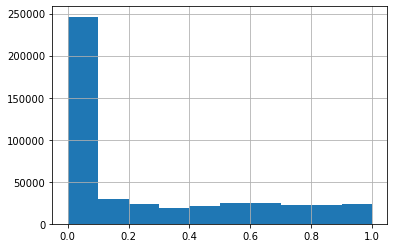

In [10]:
oof_df[f"{CFG.ver}_{CFG.model}_oof"].hist()